# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [2]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [3]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


In [4]:
# Understand home prices that will be helpful for customers to see what houses fit their price range
# Also to determine to the cost of houses based on square feet, lot etc.

**1.2:**  How will your solution be used?


In [5]:
# Gives more accurate home prices
# Customers can determine if this is what they are looking for

**1.3:**  How should success (or failure) be measured?


In [6]:
# Success would be more people are logging into zillow and using it
# Failure would be a decrease in the number of people coming to zillow.com

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  ...  yardbuildingsqft17  yardbuildingsqft26  \
0    

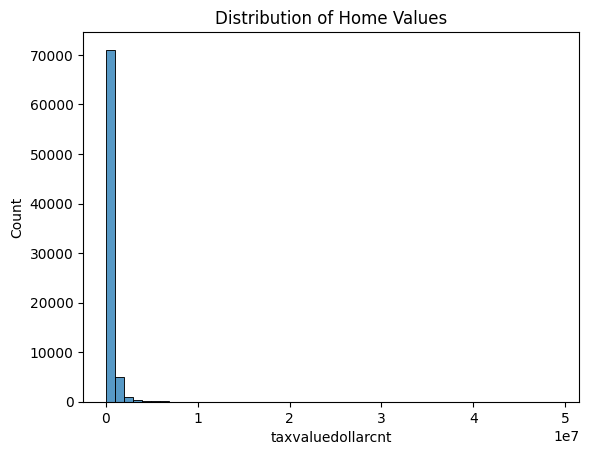

count    7.757800e+04
mean     4.901506e+05
std      6.537979e+05
min      1.000000e+03
25%      2.068985e+05
50%      3.588785e+05
75%      5.690000e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64


In [7]:
df = pd.read_csv("zillow_dataset.csv")
print(df.head())
print(df.info())
print(df.nunique())


sns.histplot(df['taxvaluedollarcnt'], bins=50)
plt.title("Distribution of Home Values")
plt.show()

print(df['taxvaluedollarcnt'].describe())


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [8]:
# Categorical columns are hashottuborspa, propertycountylandusecode, propertyzoningdesc, fireplaceflag, taxdelinquencyflag

In [9]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.

In [10]:
# Parcel ID is useless because it does not provide any predictive value
# Transaction Date is also useless because it does not relate to home value


After analysing features from Zillow datasest, some features may be unnecessary for the model because they contain IDs that do not provide useful information for prediction. For example parcelid, propertylandusetypeid. Some are having too many missing values, making them impractical to use. And some are not directly related to property value, such as temporary or minor details.

Here are some features which may be deleted.

parcelid – It is just a unique identifier for each property and does not contribute to predicting house value.

buildingclasstypeid – Identifies construction type (e.g., wood vs. steel) but may not have a strong impact on price compared to overall property condition.

decktypeid – Identifies the presence of a deck but does not give information about deck size, making it less useful.

pooltypeid10, pooltypeid2, pooltypeid7 – These are categorical indicators of pool types, which might be redundant if poolcnt and poolsizesum already describe the presence and size of pools.

yardbuildingsqft17, yardbuildingsqft26 – These features refer to specific yard buildings (e.g., sheds) but are unlikely to have a major impact on home prices.

rawcensustractandblock, censustractandblock – These are census-based location identifiers, but they are too granular for price prediction when features like regionidzip and regionidneighborhood are available.

assessmentyear – All properties were assessed in the same year, it does not provide useful variation.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example.

In [11]:
missing_percentages = df.isnull().mean() * 100
print(missing_percentages.sort_values(ascending=False))

buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
taxdelinquencyyear              96.263513
taxdelinquencyflag              96.263513
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                     80.571554
poolcnt                         79

In [12]:
# Because of the high amount of missing values these should be removed

The following features have over 90% missing values and are likely not useful for modeling:

buildingclasstypeid (99.98%) – Almost entirely missing; unlikely to be useful.

finishedsquarefeet13 (99.94%) – Perimeter living area; redundant and almost always missing.

basementsqft (99.93%) – Very few properties have basements in many regions, so it's mostly missing.

storytypeid (99.93%) – Type of stories, but nearly absent.

yardbuildingsqft26 (99.91%) – Specific yard building type, mostly missing.

fireplaceflag (99.78%) – Binary indicator for a fireplace; better to use fireplacecnt.

architecturalstyletypeid (99.73%) – Nearly empty; unlikely to impact valuation.

typeconstructiontypeid (99.71%) – Construction type, but too many missing values.

finishedsquarefeet6 (99.50%) – Base unfinished/finished area; too much missing data.

pooltypeid10, pooltypeid2, decktypeid, poolsizesum (~98-99%) – Pool/spa types; redundant if poolcnt is included.

hashottuborspa (98.01%) – Hot tub indicator, but mostly missing.

yardbuildingsqft17 (96.91%) – Specific yard structure; nearly always missing.

taxdelinquencyflag, taxdelinquencyyear (~96.26%) – Tax delinquency data; mostly absent.

finishedsquarefeet15, finishedsquarefeet50, finishedfloor1squarefeet (92-96%) – Various square footage metrics; redundant and mostly missing.

fireplacecnt (89.32%) – Number of fireplaces; too many missing values.

threequarterbathnbr (86.97%) – Number of ¾ baths; rarely filled.

pooltypeid7, poolcnt (~79-80%) – Pool information; may not be useful if missing in most cases.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example.

In [13]:
print(df.nunique())


parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

Some features have very less unique values, should be removed because they don't add any useful information.

For example:

decktypeid (1 unique value) – Only has a single value, making it useless for prediction.

hashottuborspa (1 unique value) – No variation, so it does not contribute to the model.

poolcnt, pooltypeid10, pooltypeid2, pooltypeid7 (all 1 unique value) – If they only contain a single value, they do not help in differentiating properties.

storytypeid (1 unique value) – Does not provide any variation.

fireplaceflag (1 unique value) – Since it does not vary, it is not useful.

assessmentyear (1 unique value) – If all properties were assessed in the same year, it does not add predictive value.

taxdelinquencyflag (1 unique value) – No variation, making it irrelevant.

Some features have almost as many unique values as the number of rows, meaning they might act as unique identifiers rather than useful predictors:

parcelid (77,414 unique values, almost same as dataset size) – A unique identifier for each property, which does not help in prediction.

latitude (64,038 unique values) & longitude (62,461 unique values) – These provide precise location data but might be better replaced with categorical location-based features (e.g., regionidzip, regionidneighborhood).

rawcensustractandblock (39,188 unique values) & censustractandblock (39,006 unique values) – Almost unique per row, making them less useful.

taxvaluedollarcnt (50,949 unique values) – While it is an important variable, its high uniqueness suggests it may be better transformed into grouped categories rather than used raw.

In [14]:
# Parcelid (unique 77,414 out of 77,613) unique identifier for each property but not useful for modeling.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

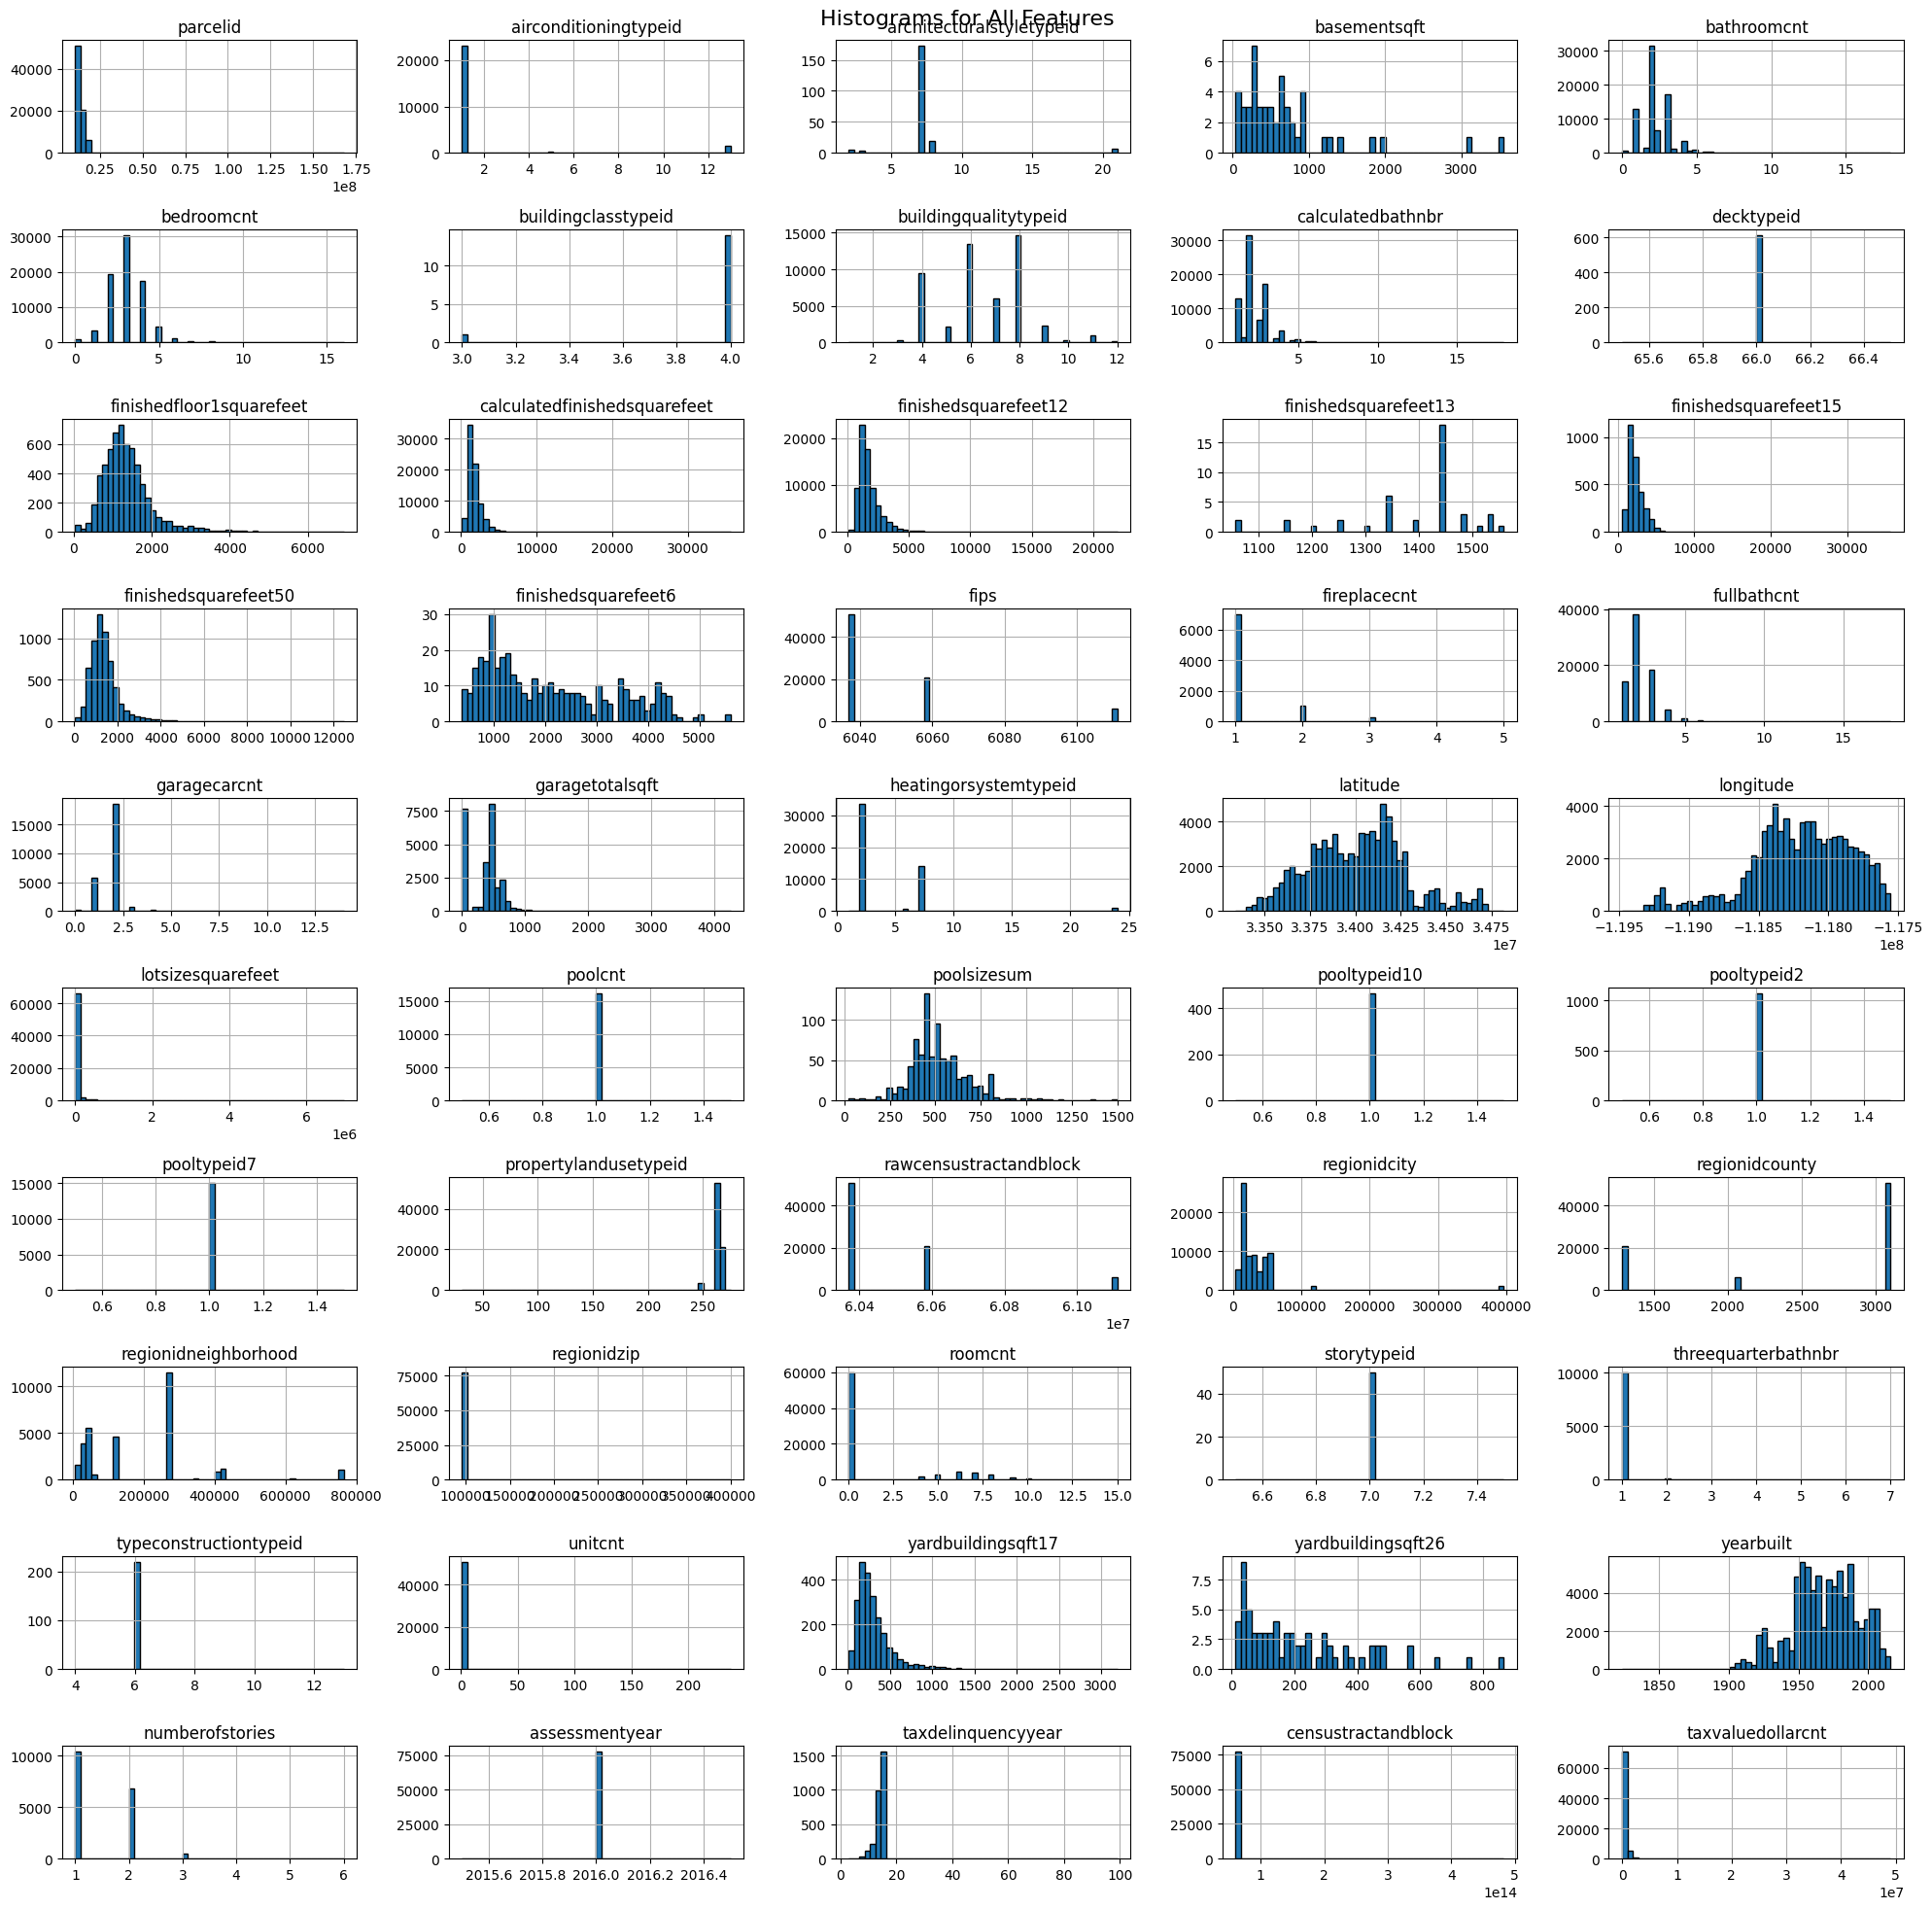

In [15]:
df.hist(figsize=(20, 20), layout=(-1, 5), bins=50, edgecolor='black')
plt.suptitle("Histograms for All Features", fontsize=16)
plt.tight_layout()
plt.show()

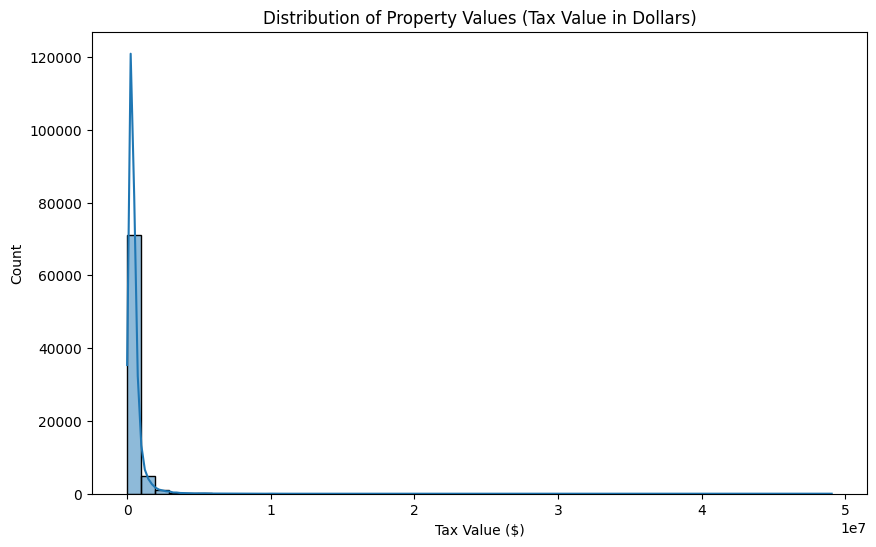

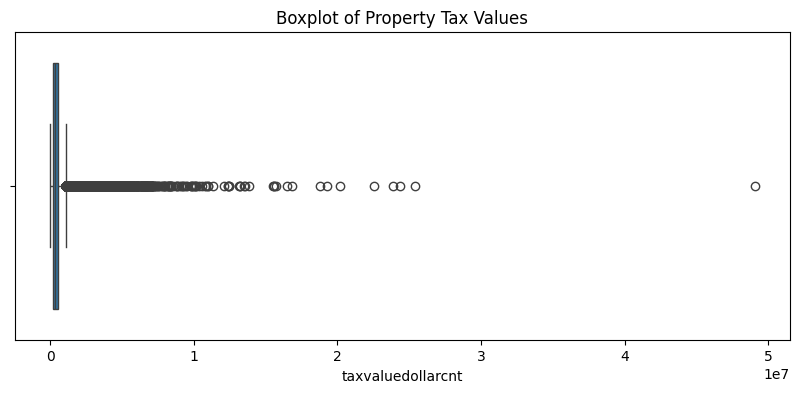

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['taxvaluedollarcnt'], bins=50, kde=True)
plt.title("Distribution of Property Values (Tax Value in Dollars)")
plt.xlabel("Tax Value ($)")
plt.ylabel("Count")
plt.show()

# Boxplot for target variable to check for outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['taxvaluedollarcnt'])
plt.title("Boxplot of Property Tax Values")
plt.show()

<ipython-input-17-25c4767b5624>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['bedroomcnt'], palette="coolwarm")


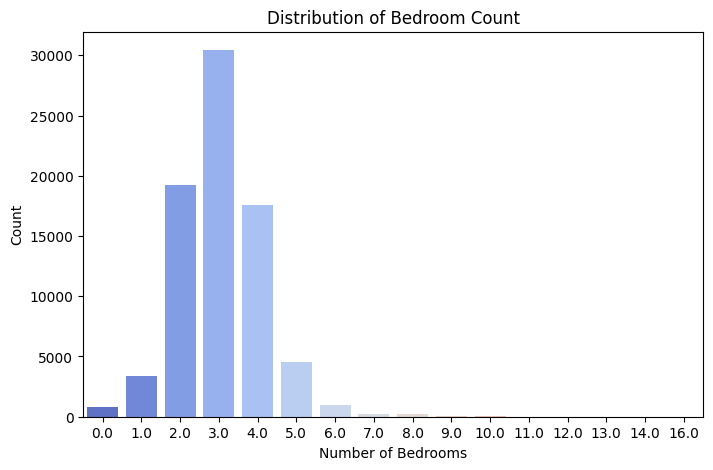

In [17]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['bedroomcnt'], palette="coolwarm")
plt.title("Distribution of Bedroom Count")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")
plt.show()

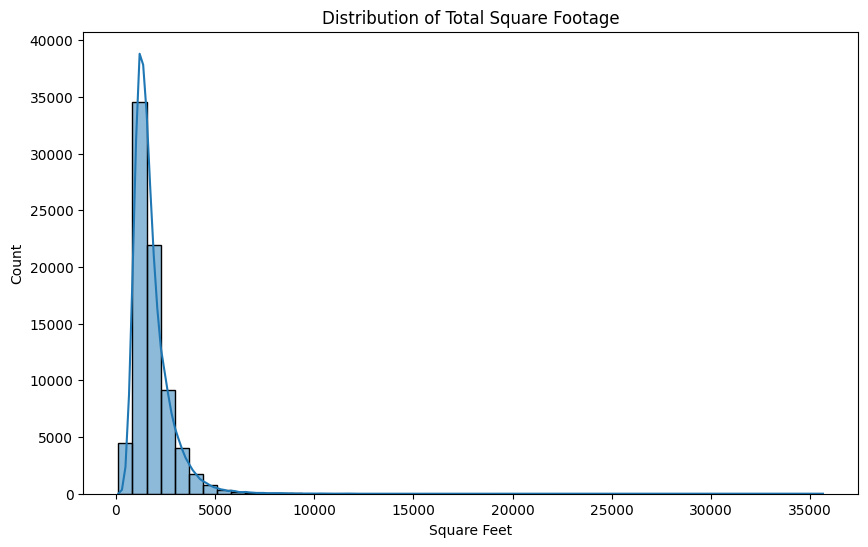

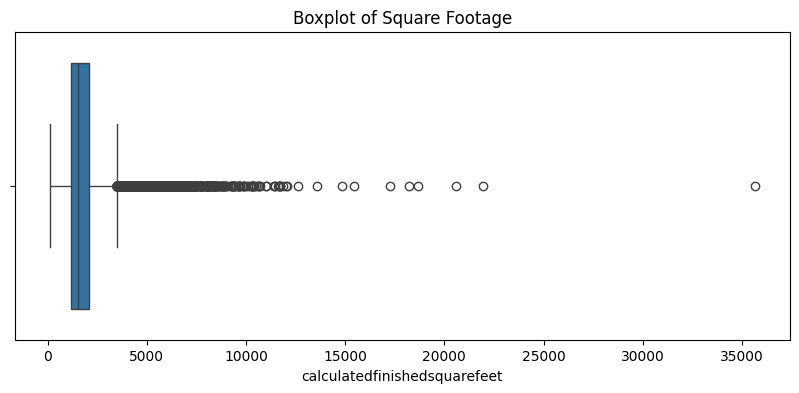

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df['calculatedfinishedsquarefeet'], bins=50, kde=True)
plt.title("Distribution of Total Square Footage")
plt.xlabel("Square Feet")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['calculatedfinishedsquarefeet'])
plt.title("Boxplot of Square Footage")
plt.show()

<ipython-input-19-ca117792947b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['garagecarcnt'], palette="viridis")


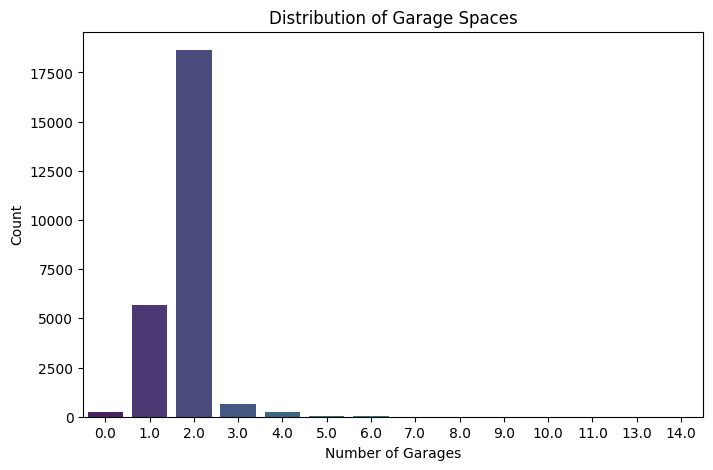

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['garagecarcnt'], palette="viridis")
plt.title("Distribution of Garage Spaces")
plt.xlabel("Number of Garages")
plt.ylabel("Count")
plt.show()

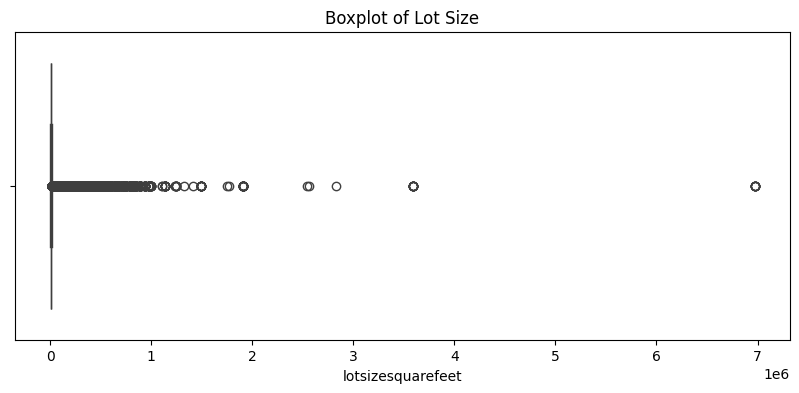

In [20]:

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['lotsizesquarefeet'])
plt.title("Boxplot of Lot Size")
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


Based on Histogram, here are three interesting features to analyze:

1. Tax Value (taxvaluedollarcnt) - Target Variable
It's right skewed distribution indicated most values are low, but some are extremely high. We itentified outliers, that indicates some properties have very high tax values, which could affect model performance.

2. Lot Size (lotsizesquarefeet) -
It indicates highly skewed distribution, which means many small values, some huge values. Boxplot shows extreme outliers that may need to be handled. Some properties have very large lots, which might affect property value.

3. Number of Bedrooms (bedroomcnt) -
It's an important feature for home pricing. Histogram shows right skewed distribution which means mostly small values (1-5), few properties with very high bedroom counts. A few extreme values (e.g., properties with 10+ bedrooms).

In [21]:
# Taxvaluedollarcnt is right-skewed, with a majority of lower-valued homes and a few extremely high-value outliers.

# Calculatedfinishedsquarefeet follows a similar right-skewed distribution, with some unusually large properties.

# Bedroom count is unimodal and categorical, mostly ranging from 2-4 bedrooms, with very few extreme cases.

# Garage count is also categorical, with most homes having 0-2 garages, and very few exceeding four.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

In [22]:
# Parcelid can be dropped because it does not contribute to predicting property value
# Assessmentyear can be dropped as well because there is no variability for prediction

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop.


We discussed to drop features for Regression task beacuse some features that don't help to predidt the house values or tax values. For example,

1. parcelid is just an ID and doesn't describe the property.

2. assessmentyear is the same for all properties, so it doesn’t add useful information.

Additionally, some features are having too many unique values, it acts like an ID rather than a useful predictor. rawcensustractandblock - almost unique for every property.

Finally, we checked some features are redundant like calculatedbathnbr and bathroomcnt since  both count bathrooms, so we might keep just one.



### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

In [23]:
threshold = 90

# Calculate percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Drop features with more than the threshold of missing values
features_to_drop = missing_percentages[missing_percentages > threshold].index
df_cleaned = df.drop(columns=features_to_drop)

# Show remaining columns
print(f"Features dropped: {features_to_drop}")
print(f"Remaining features: {df_cleaned.columns}")

Features dropped: Index(['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid',
       'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13',
       'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6',
       'hashottuborspa', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'fireplaceflag', 'taxdelinquencyflag',
       'taxdelinquencyyear'],
      dtype='object')
Remaining features: Index(['parcelid', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'pooltypeid7', 'propertycountylandusecode',
       'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustr

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



In [24]:
# I chose a threshold of 90% because features with such a high percentage of missing values are unlikely to contribute meaningfully to the model.

We chose to remove features with more than 90% missing values. If most of the data is missing, these features won't be very useful for prediction. Keeping them could also make training the model harder. For example, features like basementsqft, decktypeid, and hashottuborspa were dropped because they were missing in almost all rows. Removing them helps keep the dataset clean and improves model accuracy.

### Part 3.C: Drop Problematic **samples**

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [25]:
f_cleaned = df_cleaned.dropna(subset=['taxvaluedollarcnt'])

# 2. Drop samples with more than 50% missing values
missing_values_per_sample = df_cleaned.isnull().mean(axis=1) * 100
df_cleaned = df_cleaned[missing_values_per_sample <= 50]

# 3. Identify and drop outliers in target variable (taxvaluedollarcnt)
# Using IQR method to detect outliers in the target variable
Q1 = df_cleaned['taxvaluedollarcnt'].quantile(0.25)
Q3 = df_cleaned['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Drop samples where target variable is outside the IQR bounds
df_cleaned = df_cleaned[(df_cleaned['taxvaluedollarcnt'] >= lower_bound) &
                        (df_cleaned['taxvaluedollarcnt'] <= upper_bound)]

# Show the number of rows after cleaning
print(f"Remaining samples after cleaning: {df_cleaned.shape[0]}")

Remaining samples after cleaning: 72287


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


We removed rows where the target value (taxvaluedollarcnt) was missing because they are not useful for prediction. We also dropped samples with more than 50% missing data since they lack important information. Lastly, We removed extreme outliers in taxvaluedollarcnt using the IQR method to ensure the model isn't affected by very high or very low property values that don't represent typical cases. After cleaning the dataset remaining samples are 72287.

In [26]:
# Samples without a target value are dropped because they can't be used for training a regression model.
# I set the threshold for dropping a sample at 50% missing values. This ensures that we keep samples with enough data to make reasonable predictions.
# Outliers in Target: Extreme outliers in the target variable (property tax value) could skew the regression model, so I removed samples that are outside the 1.5*IQR range to prevent these outliers from affecting model performance.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [27]:
binary_features = ['fireplaceflag', 'hashottuborspa']

# Check if binary features are in the columns
binary_features_in_data = [col for col in binary_features if col in df_cleaned.columns]

# Impute binary features with mode if they exist
for feature in binary_features_in_data:
    df_cleaned[feature] = df_cleaned[feature].fillna(df_cleaned[feature].mode()[0])

# After applying the imputations, check if any missing values remain
print("Missing values after imputation:", df_cleaned.isnull().sum().sum())

Missing values after imputation: 606258


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


In [28]:
# For binary features like 'fireplaceflag' and 'hashottuborspa', I used mode imputation, as these features likely represent a binary yes/no scenario, where imputing the most frequent value (mode) makes sense to preserve the class distribution.

We used different imputation methods depending on the type of feature. For binary features like fireplaceflag and hashottuborspa, we filled missing values with the most common value (mode). For numerical features, we used the median to avoid outliers affecting the imputation. For categorical features, we used the mode since it represents the most frequent category. This approach helps maintain the integrity of the data while ensuring no missing values remain.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

In [29]:
categorical_features = df_cleaned.select_dtypes(include=['object']).columns

for feature in categorical_features:
    df_cleaned[feature] = df_cleaned[feature].fillna(df_cleaned[feature].mode()[0])

# Step 4: After applying the imputations, check if any missing values remain
print("Missing values after imputation:", df_cleaned.isnull().sum().sum())

Missing values after imputation: 581088


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments.

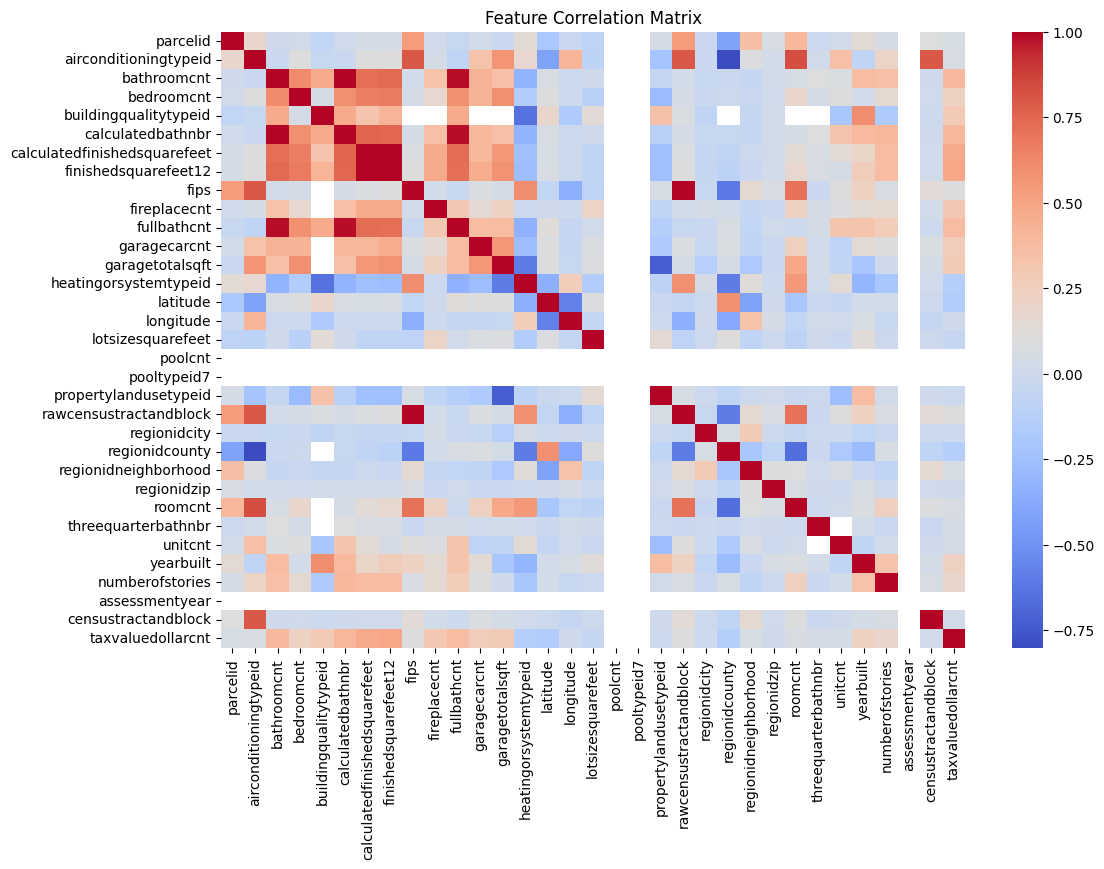

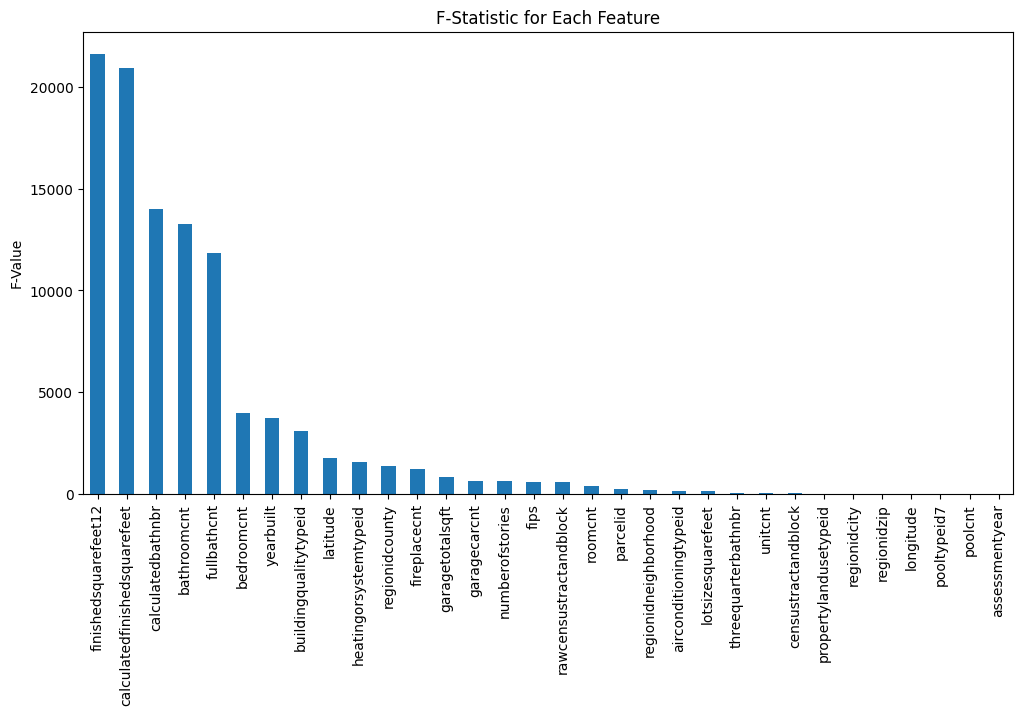

Selected Features (Forward Selection): Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'garagetotalsqft', 'latitude', 'longitude',
       'regionidcounty', 'roomcnt', 'yearbuilt'],
      dtype='object')
Selected Features (Backward Selection): Index(['bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'fips', 'garagetotalsqft', 'latitude', 'longitude',
       'rawcensustractandblock', 'roomcnt', 'yearbuilt'],
      dtype='object')


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
# Step 1: Ensure Only Numeric Data for Correlation Matrix
df_numeric = df_cleaned.select_dtypes(include=['number'])  # Keep only numerical columns

plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

# Step 2: Compute and Plot F-Statistics
X = df_numeric.drop(columns=['taxvaluedollarcnt'])  # Features
y = df_numeric['taxvaluedollarcnt']  # Target

# Impute missing values with median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

f_values, p_values = f_regression(X_imputed, y)
f_scores = pd.Series(f_values, index=X.columns)

# Plot F-Statistics
plt.figure(figsize=(12, 6))
f_scores.sort_values(ascending=False).plot(kind='bar')
plt.title("F-Statistic for Each Feature")
plt.ylabel("F-Value")
plt.show()

# Step 3: Forward and Backward Feature Selection
model = LinearRegression()
forward_selector = SequentialFeatureSelector(model, direction="forward", n_features_to_select=10)
backward_selector = SequentialFeatureSelector(model, direction="backward", n_features_to_select=10)

forward_selector.fit(X_imputed, y)
backward_selector.fit(X_imputed, y)

print("Selected Features (Forward Selection):", X.columns[forward_selector.get_support()])
print("Selected Features (Backward Selection):", X.columns[backward_selector.get_support()])

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?



The correlation matrix shows that some features are strongly related to each other, like calculatedfinishedsquarefeet and finishedsquarefeet12, which makes sense since both measure home size. High correlations could lead to multicollinearity, which might hurt model performance. The F-statistic analysis shows that features like calculatedfinishedsquarefeet and lotsizesquarefeet are strong predictors of taxvaluedollarcnt. Forward and backward selection methods helped identify the most important features, and they mostly agreed on selecting home size and location-related features. These insights will help in choosing the best features for modeling.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

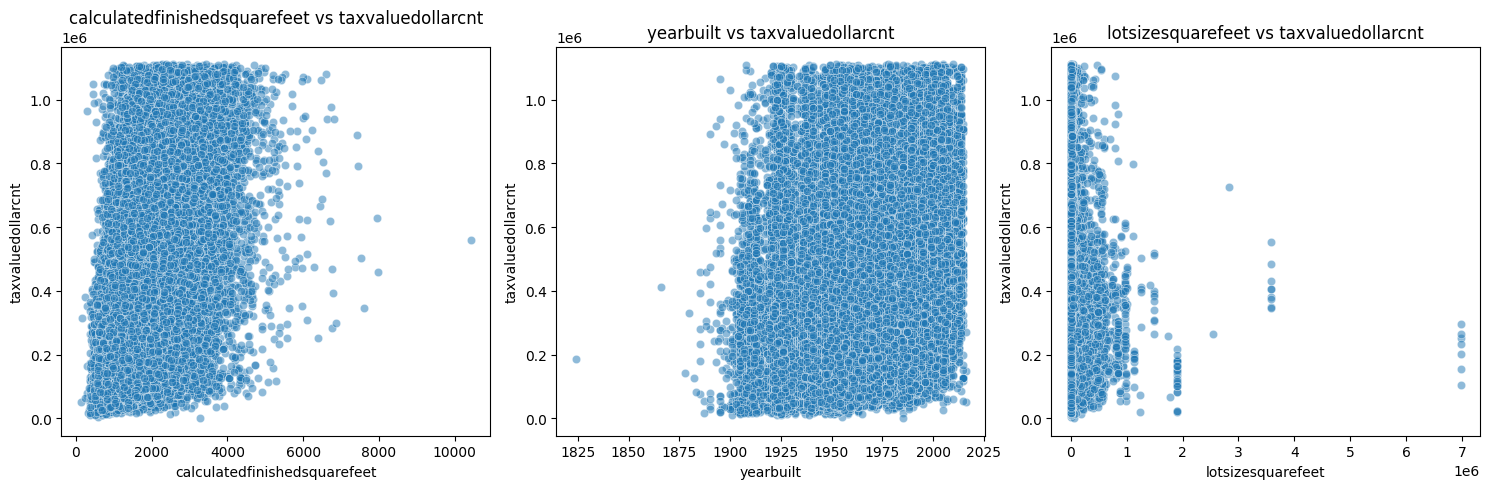

In [34]:
# Choose three interesting feature pairs
feature_pairs = [
    ('calculatedfinishedsquarefeet', 'taxvaluedollarcnt'),  # Size vs. Property Value
    ('yearbuilt', 'taxvaluedollarcnt'),  # Age of Property vs. Value
    ('lotsizesquarefeet', 'taxvaluedollarcnt')  # Lot Size vs. Value
]

# Create scatter plots
plt.figure(figsize=(15, 5))

for i, (x_feature, y_feature) in enumerate(feature_pairs, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=df_cleaned, x=x_feature, y=y_feature, alpha=0.5)
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f"{x_feature} vs {y_feature}")

plt.tight_layout()
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


Size vs. Property Value: Larger homes tend to have higher property values, but there are some properties that are large but still low in value.

Age of Property vs. Value: Newer homes generally have higher values, but some older homes are still valuable, possibly due to renovations or location.

Lot Size vs. Value: Bigger lots tend to be worth more, but there are exceptions where small lots have high value, possibly in prime locations.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.

In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
import numpy as np

# 1. Feature Scaling - Standardization
def scale_features(df, features):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])
    return df_scaled

# Example: Apply scaling to numerical features (you can select appropriate features based on your dataset)
numerical_features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']  # Example numerical features
df_scaled = scale_features(df_cleaned, numerical_features)

# 2. Log Transformation for Skewed Features
def log_transform(df, features):
    df_log = df.copy()
    for feature in features:
        df_log[feature] = np.log1p(df[feature])  # Log(1 + x) to handle zero values
    return df_log

# Example: Apply log transformation to highly skewed numerical features (if any)
log_features = ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet']  # Example skewed features
df_log_transformed = log_transform(df_cleaned, log_features)

# 3. Polynomial Features - Exploring Non-Linear Relationships
def add_polynomial_features(df, features, degree=2):
    poly = PolynomialFeatures(degree)
    df_poly = df.copy()
    poly_features = poly.fit_transform(df[features])
    poly_feature_names = poly.get_feature_names_out(features)

    # Convert to DataFrame and append to the original dataframe
    df_poly_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
    df_poly = pd.concat([df, df_poly_poly], axis=1)

    return df_poly

# Example: Apply polynomial features (degree=2) to numerical features
df_poly = add_polynomial_features(df_cleaned, numerical_features, degree=2)

# Show transformed data
df_scaled.head(), df_log_transformed.head(), df_poly.head()


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed.


In [ ]:
# Standardization was applied to ensure that all numerical features are on the same scale, which is particularly beneficial for models like KNN and SVM that rely on distance metrics. I selected logarithmic transformation for highly skewed features, such as taxvaluedollarcnt and calculatedfinishedsquarefeet, as it can reduce the impact of extreme values and bring the data closer to a normal distribution, often improving the model's performance. Finally, I introduced polynomial features to explore potential non-linear relationships between numerical features. These transformations can capture interactions that linear models might miss, thus enhancing the model's ability to learn more complex patterns.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

